In [ ]:
import os
import random
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split

# Function to resize the image for training in the same size and to obtain the dataset with the new images 

def resize_image(image_path, label_path, target_size, image_output_folder, label_output_folder, image_name, class_id=0):
    """
        Function that receibes the image and label path and save the resize image into new folder with its corresponding label
    """
    image = Image.open(image_path)
    image.thumbnail(target_size, Image.Resampling.LANCZOS)

    new_image_path = os.path.join(image_output_folder, image_name + ".png")
    image.save(new_image_path, format='PNG')

    with open(label_path, 'r') as f:
        lines = f.readlines()

    adjusted_annotations = []
    for line in lines:
        _, x_center, y_center, width, height = map(float, line.strip().split())
        adjusted_annotations.append(f"{class_id} {x_center} {y_center} {width} {height}\n")
    new_label_path = os.path.join(label_output_folder, image_name + ".txt")
    with open(new_label_path, 'w') as f:
        f.writelines(adjusted_annotations)

def process_dataset(input_folder, output_image_folder, output_label_folder, target_size, class_id=0):
    
    """"
        Function that goes thorught the dataset with the images and resize it into the new dataset
    """
    
    os.makedirs(output_image_folder, exist_ok=True)
    os.makedirs(output_label_folder, exist_ok=True)
    
    for id, cow_folder in tqdm(enumerate(Path(input_folder).iterdir())):
        if cow_folder.is_dir():
            for i, image_file in enumerate(cow_folder.glob("*.png")):
                label_file = cow_folder / (image_file.stem + ".txt")
                new_name = f'{cow_folder.name}_img_{i+1}'
                resize_image(image_file, label_file, target_size, output_image_folder, output_label_folder, new_name, class_id=0)

In [ ]:
def plot_random_cow_with_box(resized_image_folder, resized_label_folder):
    
    """
        Function that takes the image folder and label folder and plot a random image with its box
    """
    
    image_files = [image_file for image_file in os.listdir(resized_image_folder)]
    random_image_file = random.choice(image_files)

    name_file = random_image_file.replace('.png', '')
    
    label_file = f'{resized_label_folder}/{name_file}.txt'
    image_file = f'{resized_image_folder}/{name_file}.png'

    with open(label_file, 'r') as f:
        bbox = f.readline().strip().split()
        _, x_center, y_center, width, height = map(float, bbox)

    image = cv2.imread(str(image_file))
    
    img_height, img_width, _ = image.shape

    x_center_pixel = x_center * img_width
    y_center_pixel = y_center * img_height
    width_pixel = width * img_width
    height_pixel = height * img_height

    x_min = int(x_center_pixel - width_pixel / 2)
    y_min = int(y_center_pixel - height_pixel / 2)
    x_max = int(x_center_pixel + width_pixel / 2)
    y_max = int(y_center_pixel + height_pixel / 2)

    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(8, 8))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

input_dataset_folder = './Vacas/Vacas'
resized_images_folder = "./resized_images"
resized_labels_folder = "./resized_labels"
target_image_size = (640, 640)

process_dataset(input_dataset_folder, resized_images_folder, resized_labels_folder, target_size=target_image_size)

34it [02:31,  4.44s/it]


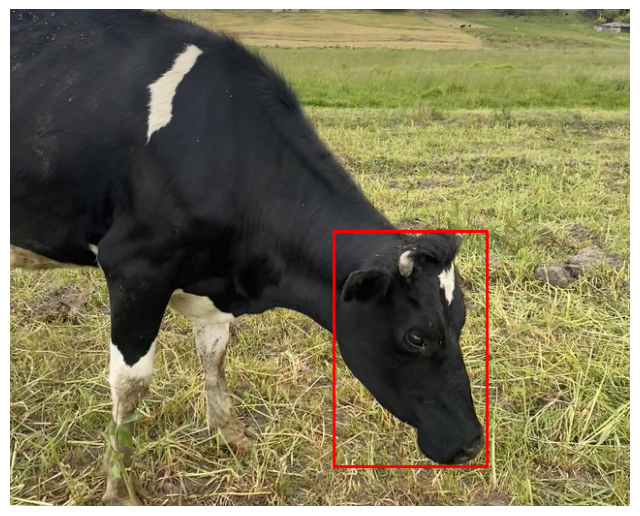

In [3]:
plot_random_cow_with_box(resized_images_folder, resized_labels_folder)

In [ ]:
def create_dataframe(input_path, label_path):
    
    """
        Creates a dataframe with the columns image_path, label_path, label (cow identifier), class_id (yolo_id=0)
    """
    
    data = []
    for image_file in os.listdir(input_path):
        name_file = image_file.replace('.png', '')
        label_file = f'{label_path}/{name_file}.txt'
        image_path = f'{input_path}/{name_file}.png'
        cow_label = image_file.split('_')[0]
        with open(label_file, 'r') as f:
            bbox = f.readline().strip().split()
            class_id, _, _, _, _ = map(float, bbox)
            
        data.append(
            {
                'image_path': image_path,
                'label_path': label_file,
                'label': cow_label,
                'class_id': class_id
            }
        )
    return pd.DataFrame(data)

df = create_dataframe('resized_images', 'resized_labels')
df.head()


,image_path,label_path,label,class_id
0,resized_images/02 rojo_img_1.png,resized_labels/02 rojo_img_1.txt,02 rojo,0.0
1,resized_images/02 rojo_img_10.png,resized_labels/02 rojo_img_10.txt,02 rojo,0.0
2,resized_images/02 rojo_img_11.png,resized_labels/02 rojo_img_11.txt,02 rojo,0.0
3,resized_images/02 rojo_img_12.png,resized_labels/02 rojo_img_12.txt,02 rojo,0.0
4,resized_images/02 rojo_img_13.png,resized_labels/02 rojo_img_13.txt,02 rojo,0.0


In [ ]:
# Divide dataset into train val and test

train_df = pd.DataFrame(columns=df.columns)
val_df = pd.DataFrame(columns=df.columns)
test_df = pd.DataFrame(columns=df.columns)


# Each folder has at least one image for each cow

labels = df['label'].unique()

for label in labels:
    label_df = df[df['label'] == label]
    train, temp = train_test_split(label_df, test_size=0.4, random_state=42)
    val, test = train_test_split(temp, test_size=0.5, random_state=42)

    train_df = pd.concat([train_df, train])
    val_df = pd.concat([val_df, val])
    test_df = pd.concat([test_df, test])
    
# The directories for each set are created with the folders for its images and labels as needed for training with YOLO

base_dir = 'partitioned_data_new'
os.makedirs(f'{base_dir}/train/images', exist_ok=True)
os.makedirs(f'{base_dir}/train/labels', exist_ok=True)
os.makedirs(f'{base_dir}/val/images', exist_ok=True)
os.makedirs(f'{base_dir}/val/labels', exist_ok=True)
os.makedirs(f'{base_dir}/test/images', exist_ok=True)
os.makedirs(f'{base_dir}/test/labels', exist_ok=True)

def move_files(df, base_dir, split):
    for _, row in tqdm(df.iterrows(), total=df.shape[0]):
        image_dst = f'{base_dir}/{split}/images/{os.path.basename(row["image_path"])}'
        label_dst = f'{base_dir}/{split}/labels/{os.path.basename(row["label_path"])}'
        shutil.copy(row["image_path"], image_dst)
        shutil.copy(row["label_path"], label_dst)

move_files(train_df, base_dir, 'train')
move_files(val_df, base_dir, 'val')
move_files(test_df, base_dir, 'test')

print(f'Train set: {len(train_df)}')
print(f'Validation set: {len(val_df)}')
print(f'Test set: {len(test_df)}')


C:\Users\flori\AppData\Local\Temp\ipykernel_13008\1239396834.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_df = pd.concat([train_df, train])
C:\Users\flori\AppData\Local\Temp\ipykernel_13008\1239396834.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  val_df = pd.concat([val_df, val])
C:\Users\flori\AppData\Local\Temp\ipykernel_13008\1239396834.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will 

Train set: 631
Validation set: 218
Test set: 231


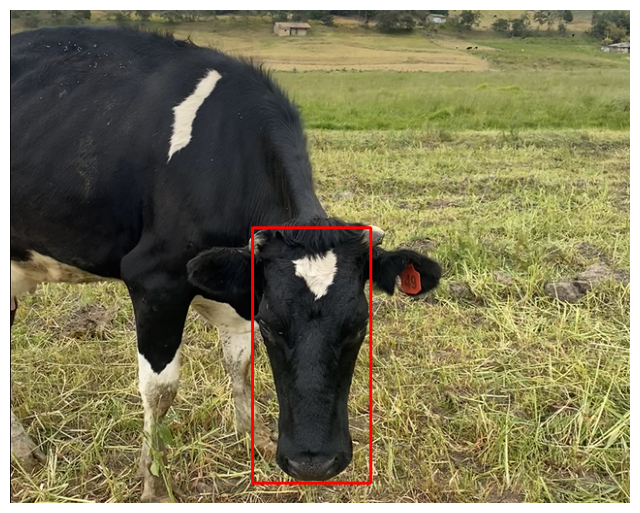

In [7]:
plot_random_cow_with_box('partitioned_data/train/images', 'partitioned_data/train/labels')